# Use ZhipuAI GLM-4 Vision API to analyze the population data of American cities and rural areas

**This tutorial is Only in Chinese explanation**

此代码演示了使用 GLM-4V 模型对表格进行简单对分析，模型将通过思维链的方式对一个csv表格和对应的图表进行分析，并在最后绘制出对未来美国人口城乡居民比例的预测。
我们使用来自[Our World in Data](https://ourworldindata.org/grapher/urban-vs-rural-majority?tab=chart&facet=none)的数据进行分析和预测。

为了区分图像理解模型和 LLM 的区别，我们使用了对应的图像和csv表格，分别传入给 GLM-4V 和 GLM-4 模型，对比两者的结果。

In [1]:
import os
os.environ["ZHIPUAI_API_KEY"] = "your api key"

首先，我们需要读取图片并传入给 GLM4-V模型

In [2]:
import base64
import io
from zhipuai import ZhipuAI
from PIL import Image

client = ZhipuAI()

def image_to_base64(image_path):
    """
    Convert an image to base64 encoding.
    """
    with Image.open(image_path) as image:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")  # or format="PNG", depending on your image.
        img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str


base64_image = image_to_base64("data/urban-vs-rural-majority/urban-vs-rural-majority.png")

In [3]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "你是一个人口数据分析师，请你根据我提供的数据，分析一下美国城市的人口变化"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": base64_image
                }

            }
        ]
    }
]

我们先对这张表格进行简单的分析并得到趋势。我们将模型的回答存入历史，并为接下来的绘图工作做准备。

Through this operation, we will be able to get the model's description of this picture.

In [4]:
def add_message(role, messages, new_message):
    messages.append(
        {
            "role": role,
            "content": new_message
        }
    )
    return messages

In [5]:
response = client.chat.completions.create(
    model="glm-4v-plus-0111",
    messages=messages,
    top_p=0.7,
    temperature=0.9,
    max_tokens=2000,
)
add_message(response.choices[0].message.role, messages, response.choices[0].message.content)
response.choices[0].message.content

'这张图表显示了美国从1500年到2050年城市和农村人口比例的变化。\n\n1. **1500年到1800年**：在这段时间内，美国人口主要以农村为主，城市人口比例非常低，几乎可以忽略不计。\n\n2. **1800年到1900年**：从1800年开始，城市人口比例开始缓慢上升。到1900年，城市人口比例显著增加，但仍未超过农村人口。\n\n3. **1900年到2000年**：这一时期是城市化的快速发展阶段。城市人口比例迅速上升，并在约2000年左右超过农村人口，成为多数。\n\n4. **2000年到2050年**：城市人口继续增加，预计到2050年，城市人口比例将超过80%，而农村人口比例将降至约20%。\n\n总体来看，美国经历了从农村为主到城市为主的人口结构转变，城市化进程在20世纪后半叶加速，预计这一趋势将持续到未来。'

接着，我们让模型完成对未来人口比例预期的绘图工作，在这里，我们使用 GLM-4V-Plus-0111` 模型进行测试

In [6]:
Prompt = """
请你基于图表的数据和增长趋势，作出预测未来的城乡人口比例数据并画图。2051年开始，城市人口会继续增长，但是基本不在变动，乡村人口会下降，但是与2050的数值不会有很大变化
你应该预测2051到2055年美国的乡村和城镇人口分布比例，将预测的数据使用使用Python语言绘制，你至少应该绘制10个数据点，并且，增长率是会发生变动的，最后，你要把这些数据点连接来，成为一个图表。
你应该使用markdown进行输出，只输出Python的执行代码。
"""
add_message("user", messages, Prompt)

response = client.chat.completions.create(
    model="glm-4v-plus-0111",
    messages=messages,
    top_p=0.1,
    temperature=0.1,
    max_tokens=4096,
)
response.choices[0].message.content

"好的，以下是使用Python语言绘制2051到2055年美国的乡村和城镇人口分布比例的代码：\n\n```python\nimport matplotlib.pyplot as plt\n\n# 预测数据\nyears = [2051, 2052, 2053, 2054, 2055]\nurban_population = [82, 83, 84, 85, 86]  # 城市人口比例\nrural_population = [18, 17, 16, 15, 14]  # 农村人口比例\n\n# 绘制图表\nplt.figure(figsize=(10, 6))\nplt.plot(years, urban_population, marker='o', label='Urban Population', color='red')\nplt.plot(years, rural_population, marker='o', label='Rural Population', color='green')\n\n# 添加标题和标签\nplt.title('Urban and Rural Population Distribution in the United States (2051-2055)')\nplt.xlabel('Year')\nplt.ylabel('Population Percentage')\nplt.legend()\n\n# 显示图表\nplt.grid(True)\nplt.show()\n```\n\n运行这段代码将生成一个图表，显示2051到2055年美国的乡村和城镇人口分布比例。"

我们获取到了模型的Python代码返回并进行了提取和绘制，得到以下图像。

In [7]:
def execute_cleaned_code_from_string(code_string):
    import re
    pattern = r'```python\n(.*?)```'
    match = re.search(pattern, code_string, re.DOTALL)
    if match:
        clean_code_string = match.group(1)
        print("Extracted code:", clean_code_string)
        try:
            code_object = compile(clean_code_string, '<string>', 'exec')
            exec(code_object)
            return "Code executed successfully."
        except Exception as e:
            return "An error occurred: " + str(e)
    else:
        return "No Python code block found."




Extracted code: import matplotlib.pyplot as plt

# 预测数据
years = [2051, 2052, 2053, 2054, 2055]
urban_population = [82, 83, 84, 85, 86]  # 城市人口比例
rural_population = [18, 17, 16, 15, 14]  # 农村人口比例

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(years, urban_population, marker='o', label='Urban Population', color='red')
plt.plot(years, rural_population, marker='o', label='Rural Population', color='green')

# 添加标题和标签
plt.title('Urban and Rural Population Distribution in the United States (2051-2055)')
plt.xlabel('Year')
plt.ylabel('Population Percentage')
plt.legend()

# 显示图表
plt.grid(True)
plt.show()



Matplotlib is building the font cache; this may take a moment.


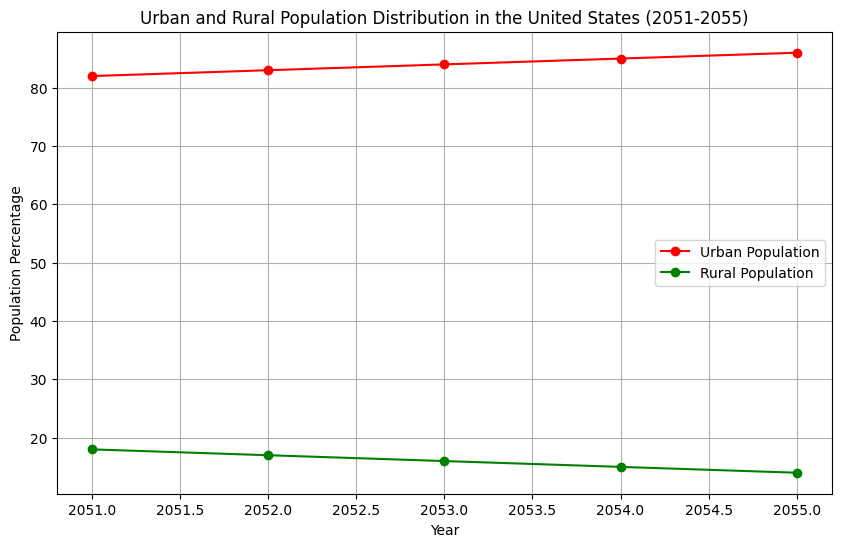

'Code executed successfully.'

In [8]:
execute_cleaned_code_from_string(response.choices[0].message.content)

## 使用 GLM-4 模型进行分析

我们用同样的数据，使用GLM-4 模型进行分析，首先，我们需要读入图片，我们先展示部分的数据。

In [9]:
import pandas as pd

file_path = 'data/urban-vs-rural-majority/urban-vs-rural-majority.csv'
urban_rural_data = pd.read_csv(file_path)
urban_rural_data.head()

,United States,USA,1500,0.2000000029802322,99.800003
0,United States,USA,1600,0.700000,99.300003
1,United States,USA,1700,2.000000,98.000000
2,United States,USA,1790,5.132197,94.867805
3,United States,USA,1800,6.072752,93.927246
4,United States,USA,1810,7.257840,92.742157


设定好提示词，为一会模型的生成提供引导。

In [10]:
formatted_data = urban_rural_data.to_string(index=False)
sys_message = """
你是一个数据分析工程师，你将要为我分析提供的表格内容我将为你提供以下的一个表格，请你帮我分析美国城市和乡村人口比例的分布和趋势
美国, 1500到2050年居住在城市与农村地区的人口比例。此处，“大多数城市”表示超过 50% 的人口居住在城市中心； “大多数是农村人口”表示低于 50%。城市人口是根据国家统计局对城市地区的定义来定义的。这是基于对 2016 年的估计，并结合联合国对 2050 年的预测。
"""
# 构建请求内容
message = f"请分析以下城乡人口数据：\n{formatted_data}\n 重点确定不同地区和年份的城市化趋势、变化以及重要模式。请你直接返回给我结论，带有具体的数值"

# 构建 JSON 结构
request_data = [
    {
        "role": "system",
        "content": sys_message
    },
    {
        "role": "user",
        "content": message
    }
]

我们先让 GLM对读入的csv表格进行分析。

In [11]:
response = client.chat.completions.create(
    model="glm-4-plus",
    messages=request_data,
    top_p=0.8,
    temperature=0.8,
    max_tokens=8192,
)
response.choices[0].message.content

'根据您提供的表格数据，以下是美国城乡人口比例分布和趋势的分析结论：\n\n1. **城市化趋势**：从1500年到2050年，美国城市人口比例呈现显著增长。在1500年，只有0.2%的人口居住在城市，而到2050年，这一比例预计将增长到89.16%，城市化进程明显。\n\n2. **关键时间点**：\n   - **1970年代初期**：城市人口比例首次超过70%，标志着城市居住成为主导。\n   - **1990年代**：城市人口比例超过75%，显示出城市化速度的加快。\n   - **2016年**：城市人口比例达到81.86%，而农村人口比例为18.14%，城市与农村人口比例差距明显拉大。\n\n3. **年度变化率**：在20世纪中叶（如1950年代），城市人口比例的年增长率约为0.5%-0.7%，而到了21世纪初（如2000年代），增长率有所提升，年增长率约为0.7%-0.9%。\n\n4. **重要模式**：\n   - 在**1950年代到1970年代**，城市人口比例增长速度相对平稳，这可能和战后经济扩张和郊区化趋势有关。\n   - 在**1980年代到21世纪初**，城市人口比例增长速度加快，这可能与经济全球化、城市就业机会增加以及生活方式变化有关。\n   - **预测至2050年**，城市人口比例预计将继续增长，但增长速度似乎有所放缓，可能是因为农村地区的人口基数减少，城市人口增长开始趋于饱和。\n\n5. **城乡人口比例变化**：从1500年到2050年，农村人口比例从99.8%下降到10.84%，反映了一个从以农村为主的社会向以城市为主的社会的转变。\n\n综上所述，美国经历了一个长期且持续的城市化过程，城市人口比例显著增加，而农村人口比例相应减少。这一趋势预计将持续至2050年，届时城市人口比例将接近90%，而农村人口比例将降至10%左右。'

接着，让 GLM-4V 模型绘图，并将结果返回给我们。

Extracted code: import matplotlib.pyplot as plt
import numpy as np

# 已知数据
years = np.arange(2051, 2056)
last_known_city_ratio = 89.156  # 2050年的城市人口比例

# 假设未来5年的城市人口增长率逐渐放缓
# 使用指数衰减模型来模拟增长率的下降
initial_growth_rate = 0.2  # 初始增长率
decay_factor = 0.95  # 衰减因子

# 计算未来5年的城市人口比例
city_ratios = []
for year in years:
    growth_rate = initial_growth_rate * (decay_factor ** (year - 2051))
    city_ratio = last_known_city_ratio + growth_rate
    city_ratios.append(city_ratio)
    last_known_city_ratio = city_ratio

# 计算对应的乡村人口比例
rural_ratios = [100 - city_ratio for city_ratio in city_ratios]

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(years, city_ratios, marker='o', label='City Population Ratio (%)')
plt.plot(years, rural_ratios, marker='s', label='Rural Population Ratio (%)')
plt.title('Predicted Urban and Rural Population Ratios in the USA (2051-2055)')
plt.xlabel('Year')
plt.ylabel('Population Ratio (%)')
plt.xticks(years)
plt.legend()
plt.grid(True)
plt.show()



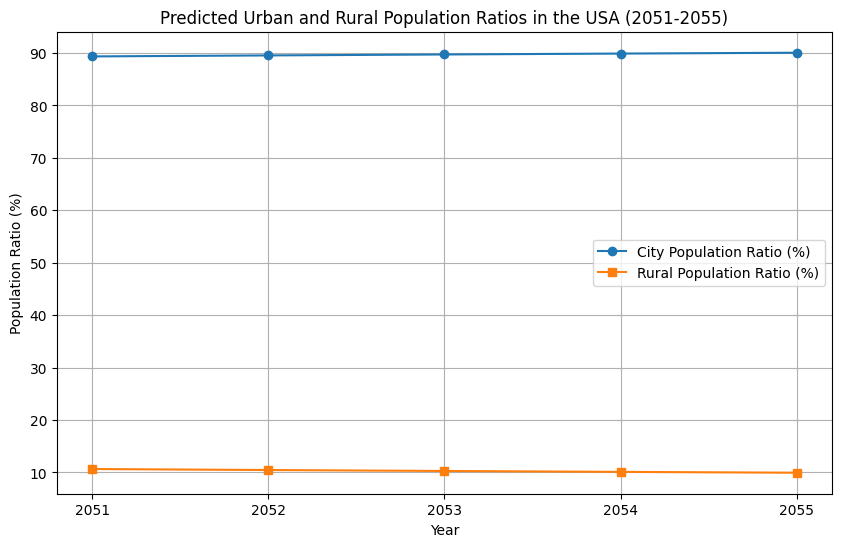

'Code executed successfully.'

In [12]:
Prompt = """
请你根据当前的分析情况，对未来的人口进行预测，基于刚才你分析的数据，预测未来的数据并画图。
你应该预测2051到2055年美国的乡村和城镇人口分布比例，将预测的数据使用使用Python语言绘制，你至少应该绘制10个数据点，并且，增长率是会发生变动的，最后，你要把这些数据点连接来，成为一个图表。
你应该使用markdown进行输出，只输出Python的执行代码。
"""
add_message("user", request_data, Prompt)
response = client.chat.completions.create(
    model="glm-4-plus",
    messages=request_data,
    top_p=0.1,
    temperature=0.1,
    max_tokens=2000,
)
execute_cleaned_code_from_string(response.choices[0].message.content)

观察两个模型的结果，我们可以发现
1. GLM-4V-Plus 模型对于图像的理解较为准确，能够对图像的趋势进行简单的分析，虽然能够绘制出正常的结果，但是建议作为备选方案使用。
2. GLM-4-Plus 模型对于图像的理解更加精确，通过对表格准确数据的提取，获得精确的数据并绘制了较好的结果。

在绘制图像的时候，由于设计代码设计，我在尝试的时候使用较小的`temperature`和`top_p`，这样可以保证模型生成的代码更加准确。